![Image embedding projection](https://raw.githubusercontent.com/arvest-data-in-context/ml-notebooks/refs/heads/main/docs/images/notebooks/image-embedding-projection.png)

In this notebook, we shall take a group of images, perform an embedding analysis using the [Distant Viewing Toolkit](https://github.com/distant-viewing/dvt), and then project this data into a 2 dimensional space. This is then exported as an annotated IIIF Manifest that can be opened in [Arvest](https://arvest.app), rendering an interface very similar to [PixPlot](https://dhlab.yale.edu/projects/pixplot/).

# 0. Setup

Let's begin by installing and importing all of the different components we will need.

In [20]:
print("Installing and importing packages...")

# Uninstall and reinstall packages for a clean environment
!pip uninstall -q -y arvestapi
!pip uninstall -q -y jhutils
!pip uninstall -q -y iiif_prezi3
!pip uninstall -q -y dvt
!pip install -q --disable-pip-version-check git+https://github.com/arvest-data-in-context/arvest-api.git
!pip install -q --disable-pip-version-check git+https://github.com/jdchart/jh-py-utils.git
!pip install -q --disable-pip-version-check git+https://github.com/iiif-prezi/iiif-prezi3.git
!pip install -q --disable-pip-version-check git+https://github.com/distant-viewing/dvt.git
!pip install -q --disable-pip-version-check opencv-python
!pip install -q --disable-pip-version-check scikit-learn
!pip install -q --disable-pip-version-check matplotlib

# Import packages
import arvestapi
from jhutils.local_files import read_json, write_json, get_audio_info, get_video_info, get_image_info
import jhutils.online_files
from jhutils.misc import print_progress_bar
import os
import dvt
import iiif_prezi3
import shutil
import requests
import json
import cv2
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
import random
import mimetypes

TEMP_FOLDER = os.path.join(os.getcwd(), "_TEMP")
if os.path.isdir(TEMP_FOLDER) == False:
    os.makedirs(TEMP_FOLDER)

print("👍 Ready!")

Installing and importing packages...
👍 Ready!


# 1. Prepare images
You will first need a corpus of images to process. Here we give the example of a collection of images hosted by the Library of Congress.

In [2]:
CORPUS_URL = "https://raw.githubusercontent.com/arvest-data-in-context/ml-notebooks/refs/heads/main/test-corpora/fsa-owi-color-photographs.json"

response = requests.get(CORPUS_URL)
if response.status_code == 200:
    corpus = json.loads(response.text)["images"]

print(f"Loaded a corpus of {len(corpus)} images.")

Loaded a corpus of 165 images.


# 2. Process embeddings
Next we can use the distant viewing toolkit to map the images within an embedding space. The first time you use dvt it will download the model onto your computer. We'll save the embedding data as a numpy file so that we don't have to run this step again.

In [8]:
EMBEDDINGS_FILE = os.path.join(os.getcwd(), "embeddings.npy")

embedder = dvt.AnnoEmbed()

for i, image_data in enumerate(corpus):
    print_progress_bar(i, len(corpus) - 1, f"Treating {os.path.basename(image_data['url'])}")
    jhutils.online_files.download(image_data["url"], dir = TEMP_FOLDER)
    image_as_np = cv2.imread(os.path.join(TEMP_FOLDER, os.path.basename(image_data["url"])))
    image_as_np = cv2.cvtColor(image_as_np, cv2.COLOR_BGR2RGB)
    embedding = embedder.run(image_as_np)["embedding"]
    if i == 0:
        embedding_list = embedding
    else:
        embedding_list = np.vstack((embedding_list, embedding))

print(embedding_list)
np.save(EMBEDDINGS_FILE, embedding_list)

|██████████████████████████████████████████████████| 100.0% Complete Treating 1a34181v.jpg
[[ 0.23093319  0.2118901   0.364574   ...  0.09283781  0.02314256
   0.1944712 ]
 [ 0.03674947  0.4208375   0.4882737  ...  0.45851144 -0.1185564
  -0.0648063 ]
 [ 0.05495544  0.41608045  0.43657443 ...  0.15191904 -0.12234852
   0.01773163]
 ...
 [ 0.13900533 -0.07040443 -0.0549368  ...  0.89675826  0.12317013
  -0.00938884]
 [-0.09091117  0.08704858  0.41765168 ...  0.5094684  -0.01115491
  -0.03740339]
 [ 0.01363899  0.3084128   0.09169351 ... -0.00226397  0.17920673
   0.02145796]]


# 3. Dimensionality reduction and clustering
Now that we have our embedding data, we can use dimensionality reduction to crunch all of these dimensions down into 2 so that they can be projected into a 2-dimensional space. To do this, we'll use an one of the following dimensionality reduction algorithms: [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), [PCA]() or [UMAP](). Note that we also do some pre- and post-processing, the full process is: standardisation -> dimensionality reduction -> normalization.

In [9]:
METHOD = "tsne"

embedding_list = np.load("embeddings.npy")
standardized = StandardScaler().fit_transform(embedding_list)


if METHOD == "tsne":
    tsne = TSNE(n_components = 2, perplexity = 50, learning_rate=200, n_iter=5000)
    reduced = tsne.fit_transform(standardized)
if METHOD == "pca":
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(standardized)
# if METHOD == "umap":
#     reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean')
#     reduced = reducer.fit_transform(standardized)

normalized = MinMaxScaler((0, 1)).fit_transform(reduced)

print(normalized)

/Users/jacob/Documents/Repos/arvest-data-in-context/ml-notebooks/venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[[6.20587051e-01 1.00000000e+00]
 [8.89075398e-01 1.44096017e-01]
 [7.66846955e-01 1.48955762e-01]
 [2.17599317e-01 4.77539629e-01]
 [6.74210310e-01 3.07329297e-02]
 [6.19801939e-01 8.68812203e-02]
 [6.94563925e-01 1.11673653e-01]
 [3.63940835e-01 4.49298322e-01]
 [5.82056046e-01 7.19071925e-01]
 [4.78032053e-01 6.91521525e-01]
 [6.26766205e-01 5.54870129e-01]
 [4.85238671e-01 3.06629956e-01]
 [8.73410344e-01 2.29565442e-01]
 [7.93131173e-01 8.64674509e-01]
 [5.80417275e-01 2.38158286e-01]
 [5.72688460e-01 7.59056449e-01]
 [8.40769231e-01 5.53440452e-01]
 [5.73417366e-01 7.44405210e-01]
 [8.12814593e-01 5.32537460e-01]
 [7.96446145e-01 5.13779759e-01]
 [7.96754777e-01 5.15111089e-01]
 [5.24809361e-01 7.78515220e-01]
 [3.76957536e-01 3.19453299e-01]
 [7.06806481e-01 2.96366870e-01]
 [2.83884615e-01 2.96386540e-01]
 [5.51289618e-01 3.23434830e-01]
 [2.55083144e-01 4.08024579e-01]
 [6.58287287e-01 6.30318522e-02]
 [3.58690798e-01 3.44189942e-01]
 [5.39062381e-01 6.38888478e-02]
 [6.554183

If we like, we can visualize the data in a scatter plot:

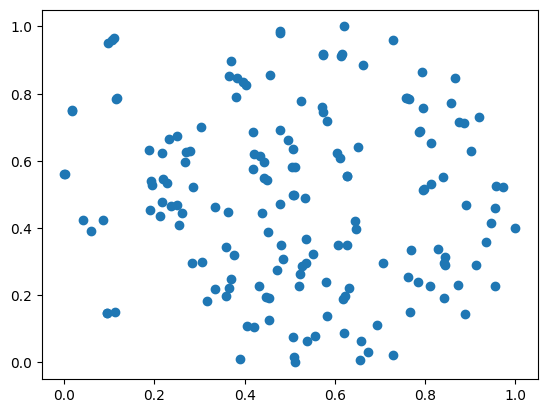

In [10]:
transposed = np.transpose(normalized)
plt.scatter(transposed[0], transposed[1])
plt.show()

## Clustering (optional)

Next we could perform some clustering on this data using [K-Means](https://en.wikipedia.org/wiki/K-means_clustering). We won't be using this data for our visualisation, but it is something that could potentially be useful.

In [11]:
NUM_CLUSTERS = 3

kmeans = KMeans(n_clusters = NUM_CLUSTERS, random_state = 0, n_init = "auto")
clusters = kmeans.fit(normalized).labels_

# Create a random colour map for visualisation:
colour_map = {}
used = []
for item in clusters:
    if item not in used:
        colour_map[str(item)] = (random.random(), random.random(), random.random())
        used.append(item)

We can visualize the clusters in a scatter plot like this:

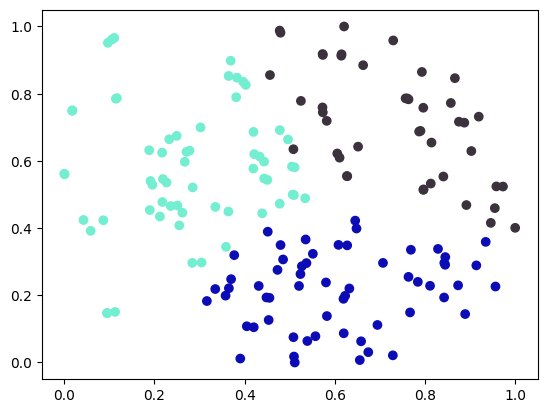

In [12]:
transposed = np.transpose(normalized)
col = []
for item in clusters:
    col.append(colour_map[str(item)])

plt.scatter(transposed[0], transposed[1], c = col)
plt.show()

# 4. Export to Arvest
Finally, we shall export the results of our analysis to an image file, and create an annotated (and therefore interactive) IIIF Manifest that can be consulted in [Arvest](https://arvest.app/en). First, we shall create a high-res PNG file that projects the corresponding images into the 2D space of the dimensionality reduction. We sahll also keep a track of the coordinates so that we can create our annotations later.

In [17]:
IMAGE_PATH = os.path.join(os.getcwd(), "visualization-image.png")
COORDINATES_PATH = os.path.join(os.getcwd(), "visualization-coordinates.json")
WIDTH = 5000
HEIGHT = 5000
PADDING = 100
IMAGE_ZOOM = 0.1

def scale(val, old_min, old_max, new_min, new_max):
    return new_min + (((val - old_min) * (new_max - new_min)) / (old_max - old_min))

def add_image(full_image, coordinates_list, image_url, coordinates):
  img_path = os.path.join(TEMP_FOLDER, os.path.basename(image_url))
  img_data = get_image_info(img_path)
  this_img = Image.open(img_path)

  w = int(img_data["width"] * IMAGE_ZOOM)
  h = int(img_data["height"] * IMAGE_ZOOM)
  x = int(scale(int(int(float(coordinates[0]) * WIDTH) - (w * 0.5)), 0, WIDTH, PADDING, WIDTH - (PADDING * 2)))
  y = int(scale(int(int(float(coordinates[1]) * HEIGHT) - (h * 0.5)), 0, HEIGHT, PADDING, HEIGHT - (PADDING * 2)))

  this_img = this_img.resize((w, h))
  full_image.paste(this_img, (x, y))

  coordinates_list.append({"url" : image_url, "x" : x, "y" : y, "w" : w, "h" : h})

# Initialize image and coordinates
full_image = Image.new('RGBA', (WIDTH, HEIGHT))
coordinates = {"images" : []}

# Add all of the images:
for i, item in enumerate(normalized):
  image_data = corpus[i]
  print_progress_bar(i, len(corpus) - 1, f"Treating {os.path.basename(image_data['url'])}")
  add_image(full_image, coordinates["images"], image_data['url'], item)

full_image.save(IMAGE_PATH)
write_json(COORDINATES_PATH, coordinates)

|██████████████████████████████████████████████████| 100.0% Complete Treating 1a34181v.jpg


## Create Manifests
Now we need to create our Manifests. In order to make the main Manifest truly interactive, we shall also make a Manifest for each of the images in our corpus. This must be done first, as we will need the URLs of these Manifests when creating our annotations.

In [ ]:
# First, let's connect to our Arvest account:
LOGIN_DATA = os.path.join(os.getcwd(), "login_private.json")
credentials = read_json(LOGIN_DATA)

ar = arvestapi.Arvest(credentials["email"], credentials["password"])
print(f"👍 Succesfully connected to Arvest with \"{ar.profile.name}\"")

👍 Succesfully connected to Arvest with "JH"


In [23]:
MANIFEST_DICT = {}

for i, image_data in enumerate(corpus):
  print_progress_bar(i, len(corpus) - 1, f"Treating {os.path.basename(image_data['url'])}")

  img_path = os.path.join(TEMP_FOLDER, os.path.basename(image_data['url']))
  img_filename = os.path.splitext(os.path.basename(image_data['url']))[0]
  img_data = get_image_info(img_path)

  manifest = iiif_prezi3.Manifest(
    id = f"https://placeholder.com/{img_filename}.json",
    label = {"en" : [f"{img_filename}"]}
  )

  # Next we create Canvas, think of this as a page in your Manifest:
  canvas = iiif_prezi3.Canvas(
      id = "https://placeholder.com/canvas/1",
      label = {"en" : [f"{os.path.basename(image_data['url'])}"]}
  )

  # Next we need to add the media file:
  annotation_page = iiif_prezi3.AnnotationPage(id = "https://placeholder.com/canvas/1/page/1")
  media_annotation_element = iiif_prezi3.Annotation(
      id = "https://placeholder.com/canvas/1/page/1/1",
      motivation = "painting",
      target = "https://placeholder.com/canvas/1"
  )
  mime_type, encoding = mimetypes.guess_type(img_path)
  body = {
      "id" : image_data['url'],
      "type" : mime_type.split("/")[0].capitalize(),
      "format" : mime_type
  }

  media_annotation_element.target = media_annotation_element.target + f"#xywh=0,0,{img_data['width']},{img_data['height']}"
  body["width"] = img_data['width']
  body["height"] = img_data['height']
  canvas.width = img_data['width']
  canvas.height = img_data['height']

  media_annotation_element.body = body
  annotation_page.items.append(media_annotation_element)
  canvas.items.append(annotation_page)
  manifest.items.append(canvas)

  local_path = os.path.join(TEMP_FOLDER, f"{os.path.splitext(os.path.basename(image_data['url']))[0]}.json")
  write_json(local_path, manifest.dict())

  added_manifest = ar.add_manifest(path = local_path, update_id = True)
  added_manifest.update_title(f"{os.path.splitext(os.path.basename(image_data['url']))[0]}")
  added_manifest.update_description("Local view of an image embedding projection.")
  
  # Update metadata:
  manifest_metadata = added_manifest.get_metadata()
  manifest_metadata["creator"] = "Batch media upload example script"
  manifest_metadata["identifier"] = "&&BATCH_UPLOAD"
  added_manifest.update_metadata(manifest_metadata)

  MANIFEST_DICT[image_data['url']] = added_manifest.get_full_url()

|██████████████████████████████████████████████████| 100.0% Complete Treating 1a34181v.jpg


In [24]:
print(MANIFEST_DICT)

{'https://tile.loc.gov/storage-services/service/pnp/fsac/1a33000/1a33800/1a33849v.jpg': 'https://resource.arvest.app/600e10a590445f4fae94ebe32cba4b0857701c3f/1a33849v.json', 'https://tile.loc.gov/storage-services/service/pnp/fsac/1a33000/1a33800/1a33858v.jpg': 'https://resource.arvest.app/e37ed5be44f96eb2906029944b4c9479199d62b9/1a33858v.json', 'https://tile.loc.gov/storage-services/service/pnp/fsac/1a34000/1a34300/1a34319v.jpg': 'https://resource.arvest.app/11f077271d16a73d8f0597359972f29735470fed/1a34319v.json', 'https://tile.loc.gov/storage-services/service/pnp/fsac/1a33000/1a33800/1a33876v.jpg': 'https://resource.arvest.app/c00bd1d84156e9a10dac05443791ba6a0d3ec5df/1a33876v.json', 'https://tile.loc.gov/storage-services/service/pnp/fsac/1a34000/1a34300/1a34320v.jpg': 'https://resource.arvest.app/89ca8f5e5d8d8711f671a28da6c01a63330bce8b/1a34320v.json', 'https://tile.loc.gov/storage-services/service/pnp/fsac/1a34000/1a34300/1a34321v.jpg': 'https://resource.arvest.app/7d8d4f9436bdade133

Now we can create the Manifest for the visualization which will point to all of the various Manifests we have just created.